<a href="https://colab.research.google.com/github/milenaonmaui/Udacity_pytorch/blob/master/Less_6_15_MNIST_MLP_w_validation_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import libraries
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
#number of subprocesses for data loading
num_workers =0 
#how many samples per batch to load
batch_size = 20

#what % of data to take for validation set
valid_size = 0.2



Convert data to torch.FloatTensor - data is 32-bit floating point
CPU tensor is torch.FloatTensor, GPU tensor is torch.cuda.FloatTensor
torch.Tensor is an alias for the default tensor type (torch.FloatTensor)


In [0]:
transform = transforms.ToTensor()
# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)



In [0]:
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

Visualize the data to make sure data is loaded correctly

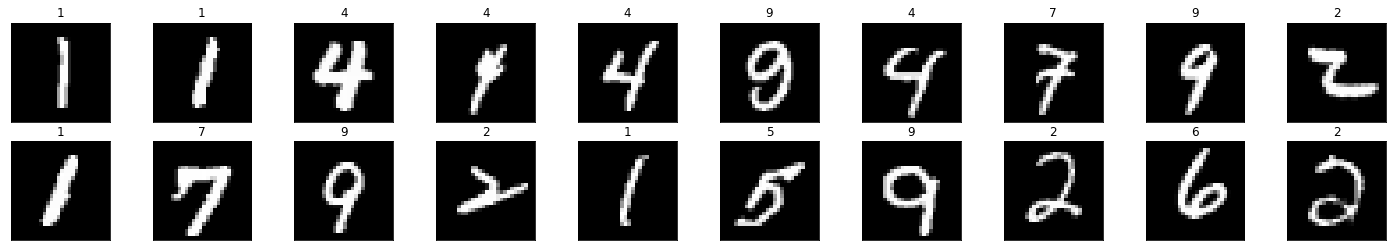

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

#get a batch of images and their correct labels
dataiter = iter(train_loader)
images, labels= dataiter.next()

#convert to numpy array
images = images.numpy()

#plot 20 images
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))


In [32]:
import torch.nn as nn
import torch.nn.functional as F

## TODO: Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # linear layer (784 -> 1 hidden node)
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        return x

# initialize the NN
model = Net()
print(model.parameters)

<bound method Module.parameters of Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)>


In [0]:
## Specify loss and optimization functions
from torch import optim
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [38]:
##Training
# number of epochs to train the model
n_epochs = 80

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        data, target = data.to(device), target.to(device)
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.742218 	Validation Loss: 0.202533
Validation loss decreased (inf --> 0.202533).  Saving model ...
Epoch: 2 	Training Loss: 0.126811 	Validation Loss: 0.123544
Validation loss decreased (0.202533 --> 0.123544).  Saving model ...
Epoch: 3 	Training Loss: 0.106568 	Validation Loss: 0.117273
Validation loss decreased (0.123544 --> 0.117273).  Saving model ...
Epoch: 4 	Training Loss: 0.101810 	Validation Loss: 0.114848
Validation loss decreased (0.117273 --> 0.114848).  Saving model ...
Epoch: 5 	Training Loss: 0.098900 	Validation Loss: 0.112933
Validation loss decreased (0.114848 --> 0.112933).  Saving model ...
Epoch: 6 	Training Loss: 0.096633 	Validation Loss: 0.111387
Validation loss decreased (0.112933 --> 0.111387).  Saving model ...
Epoch: 7 	Training Loss: 0.094651 	Validation Loss: 0.109945
Validation loss decreased (0.111387 --> 0.109945).  Saving model ...
Epoch: 8 	Training Loss: 0.092870 	Validation Loss: 0.108918
Validation loss decreased (0.10994

In [22]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    data, target = data.to(device), target.to(device)
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (str(i)))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.171952

Test Accuracy of     0: 100% ( 2/ 2)
Test Accuracy of     1: 100% ( 3/ 3)
Test Accuracy of     2: 75% ( 3/ 4)
Test Accuracy of     3: 100% ( 1/ 1)
Test Accuracy of     4: 100% ( 2/ 2)
Test Accuracy of     5: N/A (no training examples)
Test Accuracy of     6: 100% ( 1/ 1)
Test Accuracy of     7: 100% ( 3/ 3)
Test Accuracy of     8: 100% ( 3/ 3)
Test Accuracy of     9: 100% ( 1/ 1)

Test Accuracy (Overall): 95% (19/20)


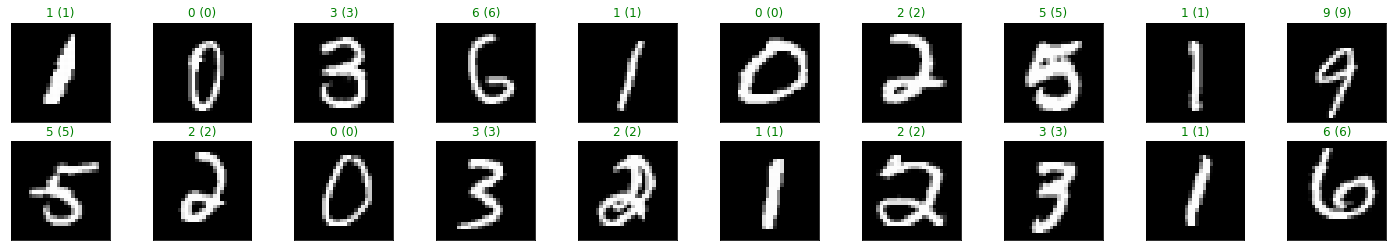

In [23]:
model.to("cpu")
# obtain one random batch of test images
rand_sampler = torch.utils.data.RandomSampler(test_data, num_samples=batch_size, replacement=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, sampler=rand_sampler)

dataiter = iter(test_loader)
images, labels = dataiter.next()
#images, labels = images.to(device), labels.to(device)
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))